In [3]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import holoviews as hv
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from pathlib import Path


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [4]:
def fancy_area(lat_array): 
    '''
    Calculate areas using science instead of g'old brute force
    
    :param lat_arrays np.array: Numpy or panda.Series of latitudes
    
    :returns: Area array in kilometers
    '''
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # Fancy calulation
    lat_array_radians = lat_array * (np.pi/180)
    areas = (R_earth*dphi)**2 * np.cos(lat_array_radians)
    
    return areas


# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product. Instead of reshaping (or re-indexing) our data, we will extract the pure values and use `pandas` to pivot everything.

In [5]:
list(Path('../cdsapi_requested_files/').rglob('*.nc'))

[PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2008_01.nc'),
 PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2007_12.nc'),
 PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2008_02.nc')]

In [6]:
era5_netcdf_files = Path('../cdsapi_requested_files/').rglob('*.nc')

list_era_nc_files = []
for reanalysis_month in era5_netcdf_files:
    
    # Load and extract data 
    xarray_data = xr.load_dataset(reanalysis_month) 
    list_era_nc_files.append(
        xarray_data
    )

In [7]:
list_era_nc_files[0]

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 217)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2008-01-01 ... 2008-01-31T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 246.05374 ... 239.10713
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-31 14:38:27 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...

Now that we have a list, we can concatenate the objects on the `time` dimension. Here `xarray` will concat the arrays across time (months in hour case). By using this, we can use the resampling and avoiding future repeated data problems (i.e. month starts in the middle of the week). 

In [8]:
test_combine = xr.auto_combine(list_era_nc_files, concat_dim='time')

<ipython-input-8-57ed30fffe82>:1: FutureWarning: In xarray version 0.15 `auto_combine` will be deprecated. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi
  test_combine = xr.auto_combine(list_era_nc_files, concat_dim='time')
<ipython-input-8-57ed30fffe82>:1: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  test_combine = xr.auto_combine(list_era_nc_files, concat_dim='time')


Now thaat we have this, we can resample by week. Since `numpy` needs a monotonic index, we need to order the time array and have dates/hours in order (note that this happens because our files are scrambled). 

In [13]:
test_combine_resample = test_combine.sortby('time').resample(time='1W').mean()
t_df = test_combine_resample.to_dataframe().reset_index(drop=False)

In [14]:
t_df

,latitude,longitude,time,t2m
0,90.0,0.00,2007-12-02,255.999161
1,90.0,0.00,2007-12-09,257.677917
2,90.0,0.00,2007-12-16,254.523102
3,90.0,0.00,2007-12-23,250.647095
4,90.0,0.00,2007-12-30,249.625519
...,...,...,...,...
14535355,-90.0,359.75,2008-02-03,236.261765
14535356,-90.0,359.75,2008-02-10,231.986404
14535357,-90.0,359.75,2008-02-17,236.440323
14535358,-90.0,359.75,2008-02-24,237.549591


### Sanity checks: number of longitudes per latitude

Sometimes things are not what are they suppose to be. 

In [15]:
# Sanity check (pick either 6hr or 12hr, they have the same shape)
# and it's named a because I have lack of imagination
a = t_df
a = a[a.time == '2007-12-02']
a_group = a.groupby(['latitude'], as_index=False).longitude.count()

print(f'The number of longitudes per latitude is: {a_group.longitude.unique()}')

The number of longitudes per latitude is: [1440]


###  _Fancy_ area calculation and temperature buckets (in Kelvin)

In [16]:
# Calculate *fancy* area and get only northern hemisphere ~ México Lindo y Querido!
ds_week_df_times = t_df[t_df.latitude > 20]
ds_week_df_times['area_grid'] = ds_week_df_times.latitude.apply(lambda x: fancy_area(x))

<ipython-input-16-972328fe413a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_week_df_times['area_grid'] = ds_week_df_times.latitude.apply(lambda x: fancy_area(x))


In [17]:
# Make cut-offs with 12-hours (more spread)
cut_off = pd.interval_range(start=int(min(ds_week_df_times.t2m)), 
                            end=int(max(ds_week_df_times.t2m)) + 5, 
                            freq=5)

ds_week_df_times = ds_week_df_times.assign(temp_bracket=pd.cut(ds_week_df_times['t2m'], 
                                                               cut_off, 
                                                               right=True))

In [18]:
# Save data for Amanda
t_df.to_csv('t2m_temp_1207_0208.csv',index=False)

In [19]:
# Calculate count of grids per group: time and temperature range
ds_week_df_north_group = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)[['latitude']].\
count().\
rename(columns = {'latitude': 'number_grids'})

ds_week_df_north_group = ds_week_df_north_group.assign(
    number_grids_cumsum = ds_week_df_north_group.number_grids.cumsum(),
    left_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.right)
)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


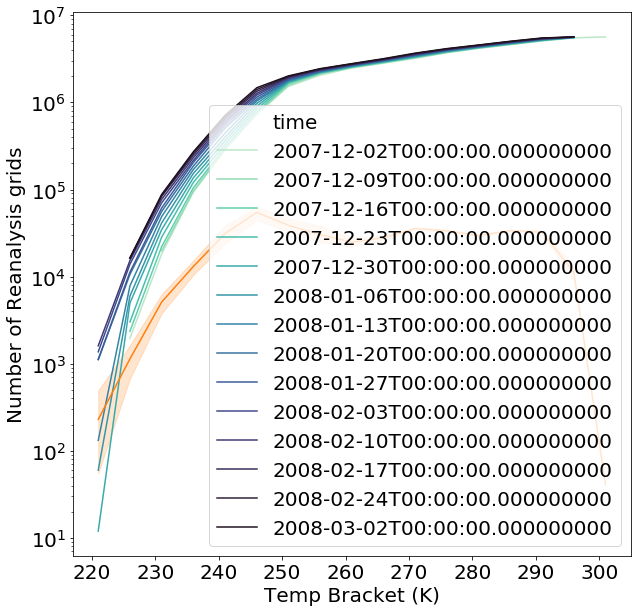

In [20]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="number_grids_cumsum", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group)
sns.lineplot(x="left_temp_interval", 
             y="number_grids",
             palette=sns.color_palette("BuGn", 14),
             data=ds_week_df_north_group,
             ax=ax,
             legend=False)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')
plt.yscale('log')

###  Calculate weekly temperature bucket covered area in the northern hemisphere [$latitude > 20$]

In [21]:
# Calculate sum of grid area per group: time and temperature range
ds_week_df_north_group_area = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)['area_grid'].\
sum().\
rename(columns = {'area_grid': 'total_area_grid'})

# There must be a better way of doing this (maybe .agg method?)
ds_week_df_north_group_area['grids_cumsum_area'] = ds_week_df_north_group_area.\
groupby('time').\
total_area_grid.\
cumsum()

ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    left_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.right)
)

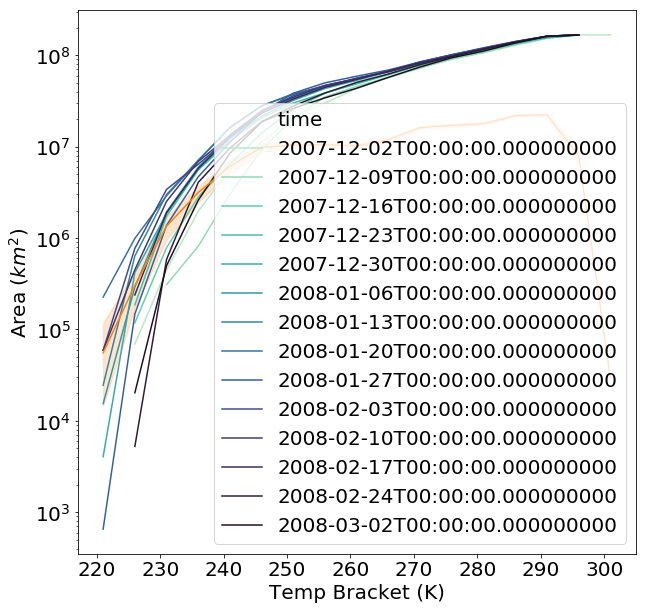

In [22]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="grids_cumsum_area", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
sns.lineplot(x="left_temp_interval", 
             y="total_area_grid",
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area,
             ax=ax)
ax.set(xlabel='Temp Bracket (K)', ylabel=r'Area ($km^{2}$)')
plt.yscale('log')

### Calculate effective latitude using math!

We can calculate the effective $(\varphi)$ latitude using the following formula:
$$
Area = 2 \pi r^{2} (1 - sin( \varphi) )
$$

From this we can rearange the equation to get: 

$$
1 - \frac{A}{2\pi r^{2}} = arcsin(\varphi)
$$

In [23]:
def eff_latitude(cdf_areas):
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    pdf_lat_effs =  np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    
    return pdf_lat_effs

In [24]:
ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    eff_lat = ds_week_df_north_group_area.grids_cumsum_area.apply(lambda x: eff_latitude(x))
) 

ds_week_df_north_group_area['eff_lat_cumsum'] = ds_week_df_north_group_area.\
groupby('time').\
eff_lat.\
fillna(0).\
cumsum(skipna=False)

[Text(0,0.5,'Effective Latitude [$\\varphi$] (radians)'),
 Text(0.5,0,'Temp Bracket (K)')]

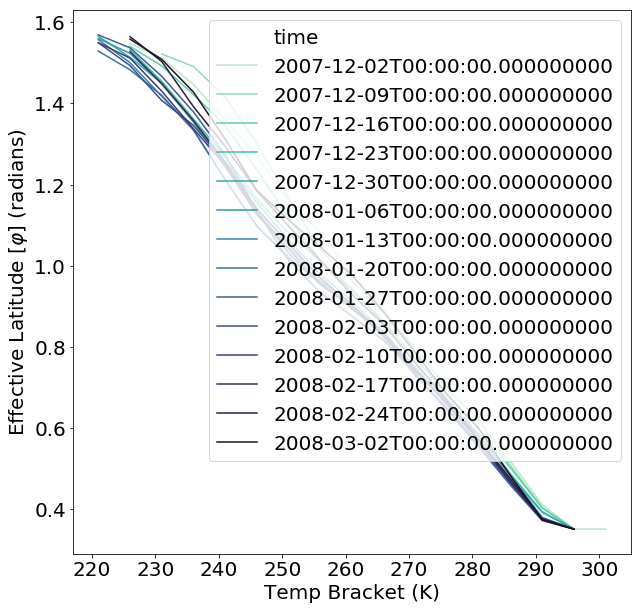

In [25]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="eff_lat", 
             hue='time', 
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
ax.set(xlabel="Temp Bracket (K)", ylabel=r'Effective Latitude [$\varphi$] (radians)')

### Calculate T' 

In [ ]:
def T_prime(lat, eff, temp):
    """
    Calculating T' using the latitude and the effective latitude
    :param lat float:
    """
    
    #take a lat,lon point
    true_lat = data_array.latitude
    true_long =data_array.longitude
    #calculate T_ref with just the latitude, given the effective lat vs temp contour relation
    T_ref = np.interp(lat, eff, binedges)
    #calculate T'(lat,lon) which is T_true(lat,lon,time) - T_ref(lat,lon,time)
    Tprime = T_ref - temp #this is a function of longitude and time
    
    return Tprime



In [68]:
test

,temp_bracket,time,total_area_grid,grids_cumsum_area,left_temp_interval,right_temp_interval,eff_lat,eff_lat_cumsum
4,"(221, 226]",2007-12-30,4.057565e+03,4.057565e+03,221,226,1.565152,1.565152
5,"(221, 226]",2008-01-06,1.541017e+04,1.541017e+04,221,226,1.559797,3.124949
6,"(221, 226]",2008-01-13,2.455927e+04,2.455927e+04,221,226,1.556911,4.681860
7,"(221, 226]",2008-01-20,2.260508e+05,2.260508e+05,221,226,1.528666,6.210526
8,"(221, 226]",2008-01-27,6.551311e+02,6.551311e+02,221,226,1.568528,7.779054
...,...,...,...,...,...,...,...,...
220,"(296, 301]",2008-02-10,6.360139e+06,1.670976e+08,296,301,0.351249,202.583923
221,"(296, 301]",2008-02-17,5.493199e+06,1.670976e+08,296,301,0.351249,202.935173
222,"(296, 301]",2008-02-24,6.038168e+06,1.670976e+08,296,301,0.351249,203.286422
223,"(296, 301]",2008-03-02,5.472044e+06,1.670976e+08,296,301,0.351249,203.637672


In [99]:
test = ds_week_df_north_group_area[ds_week_df_north_group_area.time == '2007-12-02']
test['eff_lat_deg'] = test.eff_lat.apply(lambda x: x * (180/np.pi))
latitudes = ds_week_df_times.latitude.unique()

<ipython-input-99-db90a6301018>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['eff_lat_deg'] = test.eff_lat.apply(lambda x: x * (180/np.pi))


In [119]:
a = np.interp(x = latitudes,
          xp = np.flip(test.eff_lat_deg.array),
          fp = np.flip(test.left_temp_interval.array)
          )

In [123]:
np.flip(test.left_temp_interval)

224    301
210    296
196    291
182    286
168    281
154    276
140    271
126    266
112    261
98     256
84     251
70     246
56     241
42     236
28     231
14     226
0      221
Name: left_temp_interval, dtype: category
Categories (17, int64): [221 < 226 < 231 < 236 ... 286 < 291 < 296 < 301]

<h3><center>Amanda's Functions</center></h3>

In [ ]:
def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #this is the area of each grid cell
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    areas = (R_earth*dphi)**2 * np.cos(lat)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        plots(binedges[:-1],pdf_areas,cdf_areas,'area [km^2]')
    return binedges[:-1], pdf_areas, cdf_areas


#convert area to effective latitude
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    cdf_lat_effs = np.cumsum(pdf_lat_effs)
    if plot:
        plots(binedges,pdf_lat_effs,pdf_lat_effs,'effective lat')
    return pdf_lat_effs


def T_prime(data_array,binedges,pdf_lat_effs):
    #take a lat,lon point
    true_lat = data_array.latitude
    true_long =data_array.longitude
    #calculate T_ref with just the latitude, given the effective lat vs temp contour relation
    T_ref = np.interp(true_lat,pdf_lat_effs,binedges)
    #calculate T'(lat,lon) which is T_true(lat,lon,time) - T_ref(lat,lon,time)
    Tprime = T_ref - data_array.t2m #this is a function of longitude and time
    return Tprime, data_array.longitude, data_array.time





Tmin = min(ds_week_df_times.t2m)
Tmax = max(ds_week_df_times.t2m) #kelvin

Tbins = range(int(Tmin),int(Tmax),5)
weeks = range(14)

times = ds_week_df_times.time.unique()

binedgs, pdf_area,cdf_area = dists_of_areas(data_array.t2m[times==times[0]],
                                            data_array.latitude[times==times[0]],
                                            plot=True)

pdf_lat_effs = dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)

Tprime, long, lat = T_prime(data_array,binedgs,pdf_lat_effs)

### Visualization  (daily data)

In [9]:
# Save matplotlib normals
mpl_normals = matplotlib.rcParams

In [10]:
# Downscale data to daily level and change all figsizes for plots
matplotlib.rcParams.update({'figure.figsize': (20, 15),
                           'font.size': 20})
test_combine_resample = test_combine.sortby('time').resample(time='1D').mean()

Plot daily raw data from the actic perspective (no contours)

In [11]:
# Define buckets for colorbarticks (5 Kelvin):
values = range(int(test_combine_resample.t2m.min()),
               int(test_combine_resample.t2m.max()),
              10)

for day in range(len(test_combine_resample.time.data)):
    ax = plt.axes(projection=ccrs.Orthographic(20, 90))
    test_combine_resample.t2m.isel(time=day).plot.pcolormesh(ax=ax,
                                                             cmap='RdBu_r',
                                                             vmax=int(test_combine_resample.t2m.max()),
                                                             vmin=int(test_combine_resample.t2m.min()),
                                                             transform=ccrs.PlateCarree(),
                                                             extend='neither',
                                                             cbar_kwargs={'orientation': 'horizontal',
                                                                          'pad': 0.05,
                                                                          'shrink': 0.5,
                                                                          'spacing': 'proportional'
                                                                         }
                                                 )
    plt.tight_layout()
    ax.set_global()
    ax.coastlines()
    plt.savefig(f't2m_surface_1207_0308_polar_div_{day}.png')
    plt.clf()

<Figure size 1440x1080 with 0 Axes>

Plot Effective Latitude Temperature